In [0]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os

from tensorflow.keras.layers import Input, Dense, LeakyReLU, Dropout, BatchNormalization as bn
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam as adam, SGD
from tensorflow.keras.datasets import mnist

In [2]:
data = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [0]:
(x_train, y_train), (x_test, y_test) = data

In [0]:
x_train = x_train/255 * 2 - 1
x_test = x_test/255 * 2 - 1

In [0]:
x_train = x_train.reshape(60000, 784)
x_test = x_test.reshape(10000, 784)

In [0]:
latent_dim = 200

In [0]:
def gen(latent_dim):
    i = Input(shape = latent_dim)
    x = Dense(256, activation = LeakyReLU(alpha = 0.2))(i)
    x = bn(momentum = 0.8)(x)
    x = Dense(256, activation = LeakyReLU(alpha = 0.2))(x)
    x = bn(momentum = 0.8)(x)
    x = Dense(256, activation = LeakyReLU(alpha = 0.2))(x)
    x = bn(momentum = 0.8)(x)
    x = Dense(784, activation = 'tanh')(x)

    model = Model(i, x)
    return model

In [0]:
def discriminator(size):
    i = Input(shape = (size,))
    x = Dense(512, activation = LeakyReLU(alpha = 0.2))(i)
    x = Dense(256, activation = LeakyReLU(alpha = 0.2))(x)
    x = Dense(1, activation = 'sigmoid')(x)
    
    model = Model(i, x)

    return model

In [0]:
Discriminator = discriminator(784)

Discriminator.compile(
    loss = 'binary_crossentropy',
    optimizer = adam(0.0002, 0.5),
    metrics = ['accuracy']
)

generator = gen(latent_dim)

x = Input(shape = (latent_dim,))
img = generator(x)
Discriminator.trainable = False
fake_img = Discriminator(img)

main_model = Model(x, fake_img)
main_model.compile(
    loss = 'binary_crossentropy',
    optimizer = adam(0.0002, 0.5),
)

In [0]:
batch = 32
epochs = 30000
sample_period = 200

ones = np.ones(batch)
zeros = np.zeros(batch)

discriminator_loss = []
generator_loss = []

if not os.path.exists('gan_images'):
    os.makedirs('gan_images')

In [0]:
def sample_images(epoch):
  rows, cols = 5, 5
  noise = np.random.randn(rows * cols, latent_dim)
  imgs = generator.predict(noise)

  imgs = 0.5 * imgs + 0.5

  fig, axs = plt.subplots(rows, cols)
  idx = 0
  for i in range(rows):
    for j in range(cols):
      axs[i,j].imshow(imgs[idx].reshape(28, 28), cmap='gray')
      axs[i,j].axis('off')
      idx += 1
  fig.savefig("gan_images/%d.png" % epoch)
  plt.close()

In [12]:
for epoch in range(epochs):

  idx = np.random.randint(0, x_train.shape[0], batch)
  real_imgs = x_train[idx]

  noise = np.random.randn(batch, latent_dim)
  fake_imgs = generator.predict(noise)

  d_loss_real, d_acc_real = Discriminator.train_on_batch(real_imgs, ones)
  d_loss_fake, d_acc_fake = Discriminator.train_on_batch(fake_imgs, zeros)
  d_loss = 0.5 * (d_loss_real + d_loss_fake)
  d_acc  = 0.5 * (d_acc_real + d_acc_fake)
  
  noise = np.random.randn(batch, latent_dim)
  g_loss = main_model.train_on_batch(noise, ones)
  
  noise = np.random.randn(batch, latent_dim)
  g_loss = main_model.train_on_batch(noise, ones)
  
  discriminator_loss.append(d_loss)
  generator_loss.append(g_loss)
  
  if epoch % 100 == 0:
    print(f"epoch: {epoch+1}/{epochs}, d_loss: {d_loss:.2f}, \
      d_acc: {d_acc:.2f}, g_loss: {g_loss:.2f}")
  
  if epoch % sample_period == 0:
    sample_images(epoch)


epoch: 1/30000, d_loss: 0.57,       d_acc: 0.50, g_loss: 0.47
epoch: 101/30000, d_loss: 0.02,       d_acc: 1.00, g_loss: 3.96
epoch: 201/30000, d_loss: 0.22,       d_acc: 0.94, g_loss: 2.61
epoch: 301/30000, d_loss: 0.69,       d_acc: 0.48, g_loss: 0.74
epoch: 401/30000, d_loss: 0.62,       d_acc: 0.50, g_loss: 0.71
epoch: 501/30000, d_loss: 0.61,       d_acc: 0.66, g_loss: 0.74
epoch: 601/30000, d_loss: 0.62,       d_acc: 0.61, g_loss: 0.81
epoch: 701/30000, d_loss: 0.58,       d_acc: 0.75, g_loss: 0.87
epoch: 801/30000, d_loss: 0.58,       d_acc: 0.73, g_loss: 0.88
epoch: 901/30000, d_loss: 0.56,       d_acc: 0.81, g_loss: 0.89
epoch: 1001/30000, d_loss: 0.64,       d_acc: 0.56, g_loss: 0.93
epoch: 1101/30000, d_loss: 0.58,       d_acc: 0.80, g_loss: 0.94
epoch: 1201/30000, d_loss: 0.52,       d_acc: 0.80, g_loss: 1.00
epoch: 1301/30000, d_loss: 0.56,       d_acc: 0.78, g_loss: 1.05
epoch: 1401/30000, d_loss: 0.57,       d_acc: 0.72, g_loss: 0.98
epoch: 1501/30000, d_loss: 0.57,     

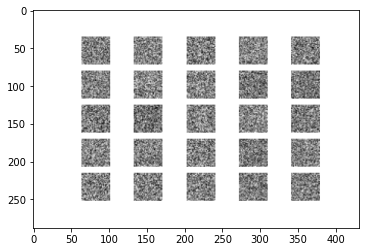

In [14]:
from skimage.io import imread
a = imread('gan_images/0.png')
plt.imshow(a)


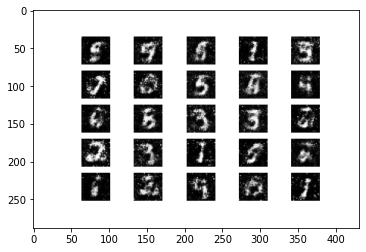

In [15]:
a = imread('gan_images/2000.png')
plt.imshow(a)

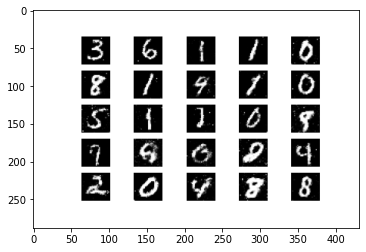

In [16]:
a = imread('gan_images/20000.png')
plt.imshow(a)

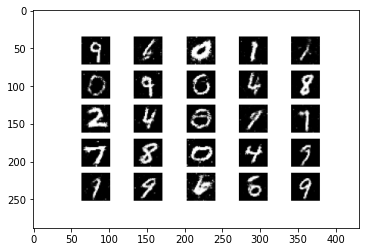

In [17]:
a = imread('gan_images/25000.png')
plt.imshow(a)

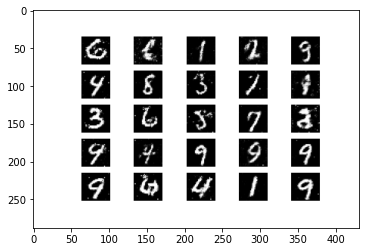

In [20]:
a = imread('gan_images/29800.png')
plt.imshow(a)